## Evaluating the `roberta-base-go_emotions` model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/samlowe/go_emotions-dataset/blob/main/eval-roberta-base-go_emotions.ipynb)

Source: https://github.com/samlowe/go_emotions-dataset/blob/main/eval-roberta-base-go_emotions.ipynb

### Init

In [1]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.models.TRANSFORMER import TransformerClassifier
from src.models.LSTM import LSTMClassifier
from transformers import BertModel
from src.local_datasets.goemotions import GoEmotionsDataset
from src.local_datasets.yelp import YelpDataset
from torch.utils.data import DataLoader
from torch.nn import functional as F


/home/mhassa2s/miniconda3/envs/nlp-proj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-08 23:55:01.962810: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-08 23:55:02.010779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 23:55:02.891866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

### Load the dataset

We just want the dataset test split here for evaluation

In [2]:
split_name = "test"

goemotions = datasets.load_from_disk("data/goemotion_tokenized.hf")
print(goemotions[split_name].column_names)

['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask']


In [28]:
label = goemotions[split_name].features["labels"].feature.names
text = goemotions[split_name]['text']
print({i: l for i, l in enumerate(label)})
print(text[0], label[0])

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}
I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett! admiration


Load into a `y_target` stucture of arrays by label (since we wish to evaluate per label for a multi-label, multi-class dataset like this)

In [4]:
num_items, num_labels = len(goemotions[split_name]), len(labels)
y_targets_all = np.zeros((num_items, num_labels), dtype=int)
for i, labels_indices in enumerate(goemotions[split_name]["labels"]):
    for label_index in labels_indices:
        y_targets_all[i, label_index] = 1

print(y_targets_all[0:3])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Load the model and run it

Loading in a multi-label, multi-class classifier model based on Roberta-base

In [5]:
lstm_goem_model = LSTMClassifier(input_dim=30522,
                                 hidden_dim=768,
                                 n_layers=2,
                                 num_classes=28,
                                 dropout=0.3,
                                )

In [6]:
classifier = torch.load("final_models/best_eval_epoch__192003_goemotions_lstm_model.pt", map_location=torch.device('cpu'))
lstm_goem_model.load_state_dict(classifier)
lstm_goem_model.eval()

LSTMClassifier(
  (embedding): Embedding(30522, 768)
  (lstm): LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=1536, out_features=28, bias=False)
  (dropout_layer): Dropout(p=0.3, inplace=False)
)

Very simple to then run the pipeline on the dataset test split.
- c.5k items so can be run on a decent CPU in a few minutes (E.g. 3.5 mins on a 11th gen i7 laptop)
- (will take signifcantly longer on a free Colab instance's 2 core CPU)
- or of course via a GPU in seconds. 

In [29]:
goemotions_pytorch = GoEmotionsDataset(split=split_name)
dataloaders = torch.utils.data.DataLoader(goemotions_pytorch, batch_size=1, shuffle=False)
for i, (inputs, targets,_) in enumerate(dataloaders):
    print(text[i],"True: ", label[targets], "Pred: ", label[torch.argmax(lstm_goem_model(inputs))])
    if i == 3:
        break

I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett! True:  sadness Pred:  remorse
It's wonderful because it's awful. At not with. True:  admiration Pred:  admiration
Kings fan here, good luck to you guys! Will be an interesting game to watch!  True:  excitement Pred:  caring
I didn't know that, thank you for teaching me something today! True:  gratitude Pred:  gratitude


In [24]:
dataloaders = torch.utils.data.DataLoader(goemotions_pytorch, batch_size=256, shuffle=False)
model = lstm_goem_model
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0
for input, labels, masks in tqdm(dataloaders):
    output = model(input)
    correct_predictions += (output.argmax(dim=1) == labels).sum().item()
    total_predictions += labels.size(0)
accuracy = correct_predictions / total_predictions
print(f"{accuracy:0.2f}")

100%|██████████| 22/22 [06:20<00:00, 17.30s/it]

0.52


The model gave us floating point outputs for each label for each item, as a list of dicts. We need to arrange these into an array to be able to easily compare them with the dataset values. These values are sometimes known as probabilities (or `probas` for short) - but note, although these values are quantitative and can be compared to an extent (as we will), they are not really probabilities in any real statistical sense. 

We still need to convert these to binary prediction (`preds`) to be able to compare them to the `y_target` values from the dataset, but since the best threshold value to use to convert them is not yet known, we'll keep the float values.

In [8]:
dataloaders = torch.utils.data.DataLoader(goemotions_pytorch, batch_size=256, shuffle=False)
model_outputs = []
for inputs, targets, _ in tqdm(dataloaders):
    outputs = lstm_goem_model(inputs)
    for output in outputs:
        model_outputs.append(F.softmax(output, dim=0).detach().numpy())


100%|██████████| 22/22 [06:44<00:00, 18.39s/it]


In [9]:
print(model_outputs[0])
y_probas_all = np.zeros((num_items, num_labels), dtype=float)
for i, item_probas in enumerate(model_outputs):
    for item_proba in item_probas:
        label, score = np.argmax(item_probas), item_proba
        y_probas_all[i, label_index] = score

[1.1042381e-02 7.8390948e-03 1.7924880e-03 1.6154133e-02 3.4720317e-02
 4.4037055e-02 1.8523481e-02 6.9922381e-03 1.0709602e-02 2.2186548e-02
 1.2291713e-02 3.2738380e-03 7.7826910e-02 1.8867380e-04 3.9061047e-03
 1.5743725e-02 8.2841255e-03 6.9770506e-03 1.3632689e-01 8.7115378e-04
 3.7835457e-03 1.6941715e-04 1.2720388e-02 5.1031221e-04 4.2387488e-01
 8.7594174e-02 2.5668507e-04 3.1403065e-02]


In [30]:
model_outputs = np.array(model_outputs).reshape(-1, 28)
i = 0
print(goemotions[split_name][i])
print(np.round(model_outputs[i]).tolist())
top = np.argmax(model_outputs[i])
print(f"Top label proba is label number {top} ({label[top]}): {model_outputs[i][top]}")

{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!', 'labels': [25], 'id': 'eecwqtt', 'input_ids': [101, 1045, 1521, 1049, 2428, 3374, 2055, 2115, 3663, 1024, 1006, 2348, 1045, 2293, 1996, 3415, 20066, 21850, 2527, 1010, 25022, 24714, 2050, 1010, 1998, 20862, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Evalutation

We'll use good old SKLearn for evaluation here because it's super well known and simple. You could use something else, such as Huggingface Evaluate if you prefer.

In [33]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

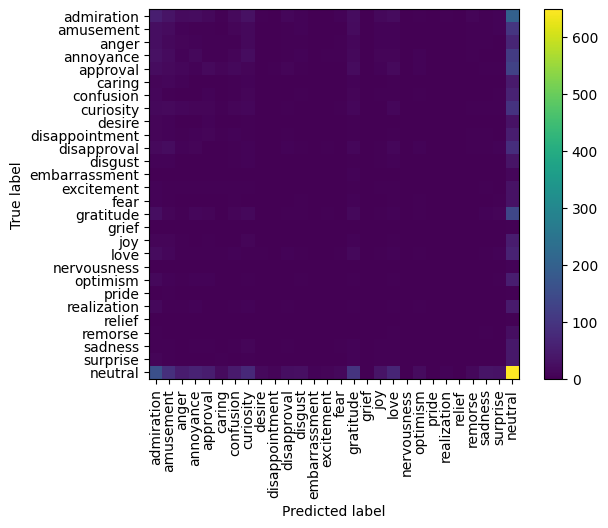

In [45]:
preds = np.argmax(model_outputs, axis=1)
targets = np.argmax(y_targets_all, axis=1)
cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(xticks_rotation='vertical', values_format='d', include_values=False)

In [61]:
auc = roc_auc_score(y_targets_all, model_outputs, average='macro')
print(f"AUC: {auc}")
report = metrics.classification_report(y_targets_all, model_outputs > 0.5, target_names=label)
print(report)

AUC: 0.5074651674844349
                precision    recall  f1-score   support

    admiration       0.11      0.09      0.10       504
     amusement       0.06      0.06      0.06       264
         anger       0.10      0.05      0.06       198
     annoyance       0.10      0.02      0.03       320
      approval       0.11      0.03      0.04       351
        caring       0.10      0.02      0.04       135
     confusion       0.05      0.02      0.03       153
     curiosity       0.06      0.01      0.02       284
        desire       0.00      0.00      0.00        83
disappointment       0.00      0.00      0.00       151
   disapproval       0.03      0.00      0.01       267
       disgust       0.05      0.02      0.03       123
 embarrassment       0.00      0.00      0.00        37
    excitement       0.00      0.00      0.00       103
          fear       0.00      0.00      0.00        78
     gratitude       0.05      0.04      0.04       352
         grief       0.

/home/mhassa2s/miniconda3/envs/nlp-proj/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhassa2s/miniconda3/envs/nlp-proj/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can see the metrics at a threshold of 0.5 (which intuitively seems like the right one to use).

Should ignore accuracy because it isn't really helpful when applied per item for a multi-label dataset E.g. if there are 3 positive labels for a particular item but the model only gets 2 of them, accuracy will treat that as a 0/fail, not a partial success.

In [32]:
threshold = 0.5
y_preds_all = y_probas_all > threshold

print("Overall (macro)")
print("===============")
print(f"Accuracy: {metrics.accuracy_score(y_targets_all, y_preds_all):.3f}")
print(f"Precision: {metrics.precision_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"Recall: {metrics.recall_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"F1: {metrics.f1_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")

Overall (macro)
Accuracy: 0.081
Precision: 0.011
Recall: 0.009
F1: 0.010


And now per label (which is more meaningful for a multi-label, multiclass dataset such as this)

Note the support for certain labels is tiny - grief has 6 positives in the dataset test split (out of c5.4k items). So measurement of the test set for such labels is meaningless, and anyway (given there is a similarly tiny number in the training split) unsurprisingly the model fails to predict positives for such labels since it's been trained on overwhelmling negative examples.

We really should prune any labels with less than (for example) 50 positive examples in the training split (which is significantly bigger than the test split we are looking at here), or we should augment the data synthetically for these tiny/scarce labels to allow the model to learn these signals.

However, they have been left in here for visibility.

In [13]:
def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "accuracy": metrics.accuracy_score(y_targets, y_preds),
        "precision": metrics.precision_score(y_targets, y_preds, zero_division=0),
        "recall": metrics.recall_score(y_targets, y_preds, zero_division=0),
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "mcc": metrics.matthews_corrcoef(y_targets, y_preds),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

In [14]:
threshold = 0.001
y_preds_all = (model_outputs > threshold).astype(int)

results = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
    results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

per_label_results = pd.DataFrame(results, index=labels)
display(per_label_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.274,0.091,0.756,0.162,-0.014,504,0.001
amusement,0.260,0.048,0.761,0.091,-0.002,264,0.001
anger,0.341,0.038,0.702,0.072,0.012,198,0.001
annoyance,0.152,0.059,0.888,0.110,-0.005,320,0.001
approval,0.089,0.065,0.974,0.122,0.003,351,0.001
caring,0.346,0.025,0.667,0.048,0.001,135,0.001
confusion,0.363,0.030,0.693,0.058,0.016,153,0.001
curiosity,0.432,0.052,0.570,0.095,-0.002,284,0.001
desire,0.529,0.016,0.506,0.032,0.009,83,0.001
disappointment,0.243,0.027,0.755,0.053,-0.007,151,0.001


Note, should probably ignore accuracy metric again, but in this case at the per-label level a multi-label dataset has a huge number of true negatives which make the accuracy figure pretty meaningless. E.g. in a situation where there are 10 positive items and 990 negative items, if a model simply predicts negative for everything, its accuracy figure still appears very high (0.99) even though its clearly not performing to a useful level.

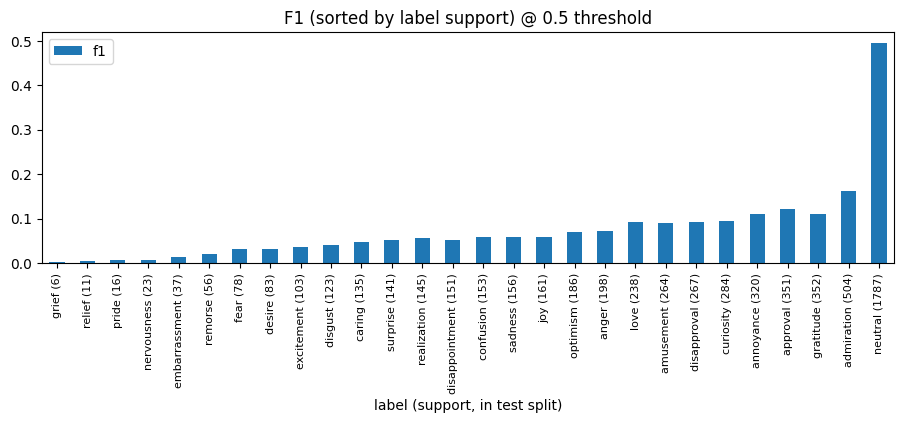

In [15]:
per_label_results["label (support)"] = (
    per_label_results.index + " (" + per_label_results["support"].astype(str) + ")"
)
ax = per_label_results.sort_values(by="support").plot.bar(
    x="label (support)",
    y=["f1"],
    rot=90,
    title="F1 (sorted by label support) @ 0.5 threshold",
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

We can recreate dataset-wide metrics from per-label metrics, which will prove useful later.

In [16]:
def dataset_wide_metrics(df):
    simple_mean = {
        m: round(df[m].mean(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Simple mean of labels:", simple_mean)
    weighted = {
        m: round(sum(df[m] * df["support"]) / df["support"].sum(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Weighted average (using support):", weighted)
    return simple_mean, weighted

_ = dataset_wide_metrics(per_label_results)

Simple mean of labels: {'precision': 0.042, 'recall': 0.56, 'f1': 0.074, 'mcc': 0.003}
Weighted average (using support): {'precision': 0.127, 'recall': 0.754, 'f1': 0.202, 'mcc': 0.003}


So, now lets do a crude search for how the metrics vary by threshold, rather than naively setting it at 0.5 as above

In [17]:
threshold_results = {}
for t in tqdm(range(5, 100, 5)):
    threshold = t / 100
    y_preds_all = (y_probas_all > threshold).astype(int)
    threshold_results[threshold] = []
    for label_index, label in enumerate(labels):
        y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
        threshold_results[threshold].append(calc_label_metrics(label, y_targets, y_preds, threshold))

100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


In [18]:
metric_name = "f1"
best = {label: {metric_name: -1, "result": None} for label in labels}
for threshold, results in threshold_results.items():
    for result in results:
        label = result["label"]
        if result[metric_name] > best[label][metric_name]:
            best[label] = {metric_name: result[metric_name], "result": result}

results = [b["result"] for b in best.values()]
per_label_threshold_results = pd.DataFrame(results, index=[result["label"] for result in results])
display(per_label_threshold_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.907,0.000,0.000,0.000,0.000,504,0.05
amusement,0.951,0.000,0.000,0.000,0.000,264,0.05
anger,0.964,0.000,0.000,0.000,0.000,198,0.05
annoyance,0.941,0.000,0.000,0.000,0.000,320,0.05
approval,0.935,0.000,0.000,0.000,0.000,351,0.05
caring,0.975,0.000,0.000,0.000,0.000,135,0.05
confusion,0.972,0.000,0.000,0.000,0.000,153,0.05
curiosity,0.948,0.000,0.000,0.000,0.000,284,0.05
desire,0.985,0.000,0.000,0.000,0.000,83,0.05
disappointment,0.972,0.000,0.000,0.000,0.000,151,0.05


Charting it

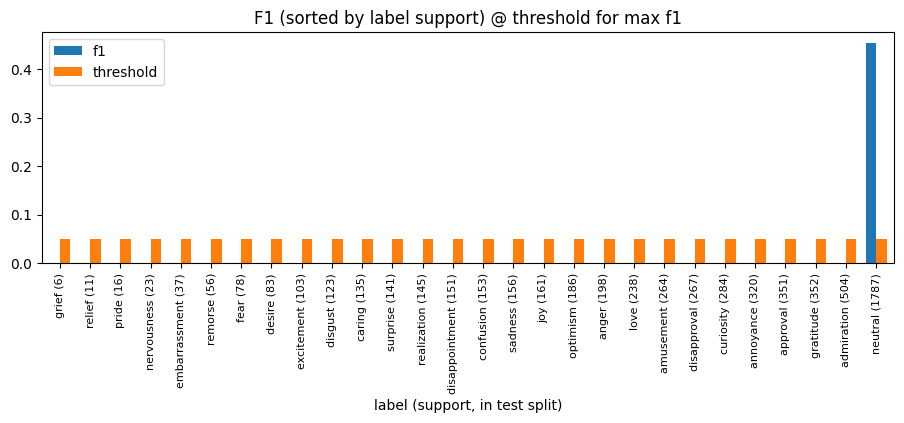

In [19]:
per_label_threshold_results["label (support)"] = (
    per_label_threshold_results["label"] + " (" + per_label_threshold_results["support"].astype(str) + ")"
)
ax = per_label_threshold_results.sort_values(by="support").plot.bar(
    x='label (support)',
    y=["f1", "threshold"],
    rot=90,
    title="F1 (sorted by label support) @ threshold for max f1",
    width=0.7,
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

Note how the best performing threshold (when measured by maximizing f1) is always a lower threshold than the 0.5 assumed before. This is likely because there are so mny true negatives in the dataset (as is often the case with multi-label, multi-class datasets).

As you'd expect precision takes a dip vs before as the model is predicting positive more often, but to a lesser degree than recall climbs, causing F1 to overall increase (since F1 is the harmonic mean of precision and recall).

The most extreme examples being the labels with the smallest support (e.g. grief) where the smallest threshold tried (0.05) is the one that cajoles the model into finally giving some positives and hence getting valid precision and recall scores that can't do if they never predict positive.

Various techniques could be used to increase the probas so these low thresholds were not the best, such as boosting/duplicating the true positives in the training set, data augmentation, or a linear layer to boost the proba output, but simply using a label-bespoke threshold here gives us a view of the perf of the model as it is. 

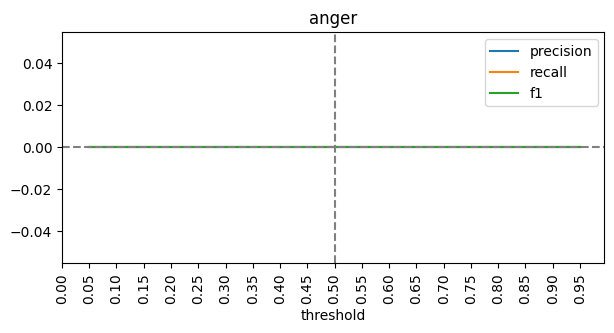

In [20]:
_label_name = "anger"
label_per_threshold_results = []
for threshold, results in threshold_results.items():
    for result in results:
        if result["label"] == _label_name:
            label_per_threshold_results.append(result)

label_per_threshold_results = pd.DataFrame(
    label_per_threshold_results, index=[r["threshold"] for r in label_per_threshold_results]
)
ax = label_per_threshold_results.plot.line(
    x="threshold", y=["precision", "recall", "f1"], rot=90, title=_label_name, figsize=(7,3)
)
ax.axvline(0.5, color='gray', linestyle='--')
ax.axhline(label_per_threshold_results["f1"].max(), color="gray", linestyle="--")
ax.xaxis.set_ticks(np.arange(0, 1, 0.05))
plt.show()

In [21]:
print("### Threshold set to arbitary 0.5")
_before = dataset_wide_metrics(per_label_results)
print()
print("### Threshold from per label search (for best F1 score)")
_after = dataset_wide_metrics(per_label_threshold_results)

print()
percentage = (_after[0]["f1"] - _before[0]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (simple mean) improved by {round(percentage, 1)}%")
percentage = (_after[1]["f1"] - _before[1]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (weighted) improved by {round(percentage, 1)}%")

### Threshold set to arbitary 0.5
Simple mean of labels: {'precision': 0.042, 'recall': 0.56, 'f1': 0.074, 'mcc': 0.003}
Weighted average (using support): {'precision': 0.127, 'recall': 0.754, 'f1': 0.202, 'mcc': 0.003}

### Threshold from per label search (for best F1 score)
Simple mean of labels: {'precision': 0.012, 'recall': 0.027, 'f1': 0.016, 'mcc': -0.001}
Weighted average (using support): {'precision': 0.092, 'recall': 0.213, 'f1': 0.128, 'mcc': -0.005}

F1 (simple mean) improved by -78.4%
F1 (weighted) improved by -100.0%


### Dataset constraints on the model performance

Some labels (E.g. gratitude) when considered independently perform very strongly with F1 around 0.9, whilst others (E.g. relief) perform very poorly. 

This is a challenging dataset. Labels such as relief do have much fewer examples in the training data (less than 100 out of the 40k+, and only 11 in the test split).

But there is also some ambiguity and/or labelling errors visible in the training data of go_emotions that is suspected to constrain the performance. Data cleaning on the dataset to reduce some of the mistakes, ambiguity, conflicts and duplication in the labelling would produce a higher performing model.